CD1_(/km^2)	0.335-0.999 mm

CD2_(/km^2)	1.00-4.75 mm

CD3_(/km^2)	4.75-200 mm

CD4_(/km^2) >200 mm

WD1_(g/km^2) 0.335-0.999 mm

WD2_(g/km^2) 1.00-4.75 mm

WD3_(g/km^2) 4.75-200 mm
		
WD4_(g/km^2) >200 mm			

In [0]:
import math
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

**PREPROCESSING DATA**

In [0]:
import pandas as pd

from google.colab import drive

drive.mount('/content/gdrive/')
pollution_data = pd.read_csv('/content/gdrive/My Drive/AI_NoteBook/PROJECT/Import_File/PlasticMarinePollutionDataset.csv')

########## [PREPROCESSING] ##########
pollution_data.rename(columns = {'CD1_(/km^2)' : 'Count_Density_Class1Plastic'}, inplace = True)
pollution_data.rename(columns = {'CD2_(/km^2)' : 'Count_Density_Class2Plastic'}, inplace = True)
pollution_data.rename(columns = {'CD3_(/km^2)' : 'Count_Density_Class3Plastic'}, inplace = True)
pollution_data.rename(columns = {'CD4 _(/km^2)' : 'Count_Density_Class4Plastic'}, inplace = True)

pollution_data.rename(columns = {'WD1_(g/km^2)' : 'Weight_Density_Class1Plastic'}, inplace = True)
pollution_data.rename(columns = {'WD2_(g/km^2)' : 'Weight_Density_Class2Plastic'}, inplace = True)
pollution_data.rename(columns = {'WD3_(g/km^2)' : 'Weight_Density_Class3Plastic'}, inplace = True)
pollution_data.rename(columns = {'WD4_(g/km^2)' : 'Weight_Density_Class4Plastic'}, inplace = True)

pollution_data['Count_Density_Class1Plastic'] = pollution_data.Count_Density_Class1Plastic.str.replace(' ', '')
pollution_data['Count_Density_Class2Plastic'] = pollution_data.Count_Density_Class2Plastic.str.replace(' ', '')
pollution_data['Count_Density_Class3Plastic'] = pollution_data.Count_Density_Class3Plastic.str.replace(' ', '')
pollution_data['Weight_Density_Class2Plastic'] = pollution_data.Weight_Density_Class2Plastic.str.replace(' ', '')
pollution_data['Weight_Density_Class3Plastic'] = pollution_data.Weight_Density_Class3Plastic.str.replace(' ', '')
pollution_data['Weight_Density_Class4Plastic'] = pollution_data.Weight_Density_Class4Plastic.str.replace(' ', '')

pollution_data['Count_Density_Class1Plastic'] = pollution_data.Count_Density_Class1Plastic.str.replace(',', '').astype(float)
pollution_data['Count_Density_Class2Plastic'] = pollution_data.Count_Density_Class2Plastic.str.replace(',', '').astype(float)
pollution_data['Count_Density_Class3Plastic'] = pollution_data.Count_Density_Class3Plastic.str.replace(',', '').astype(float)
pollution_data['Weight_Density_Class2Plastic'] = pollution_data.Weight_Density_Class2Plastic.str.replace(',', '').astype(float)
pollution_data['Weight_Density_Class3Plastic'] = pollution_data.Weight_Density_Class3Plastic.str.replace(',', '').astype(float)
pollution_data['Weight_Density_Class4Plastic'] = pollution_data.Weight_Density_Class4Plastic.str.replace(',', '').astype(float)

pollution_data = pollution_data.drop_duplicates(keep = 'first')

pollution_data['Data'] = pollution_data.Date.astype(str)

pollution_data_4 = pollution_data[['Date','Weight_Density_Class4Plastic']]

pollution_data_4 = pollution_data_4.dropna(how = 'any')

########## [REMOVE ZEROS] #########
pollution_data_4 = pollution_data_4.drop(index = pollution_data_4[pollution_data_4['Weight_Density_Class4Plastic'] == 0].index)
###################################

pollution_data_4['Date'] = pd.to_datetime(pollution_data_4.Date)

pollution_data_4_GroupByDate = pollution_data_4.groupby('Date').Weight_Density_Class4Plastic.sum()

pollution_data_4_GroupByDate = pd.DataFrame(pollution_data_4_GroupByDate)

pollution_data_4_GroupByDate ['Date'] = pollution_data_4_GroupByDate.index

######### [MOVING AVERAGES APPROACH FOR PLASTIC] ##########
pollution_data_4_GroupByDate ['Plastic_Moving_Average_9'] = pollution_data_4_GroupByDate.Weight_Density_Class4Plastic.rolling(9, center=True).mean()
pollution_data_4_GroupByDate ['Plastic_Moving_Average_21'] = pollution_data_4_GroupByDate.Weight_Density_Class4Plastic.rolling(21, center=True).mean()
pollution_data_4_GroupByDate ['Plastic_Moving_Average_36'] = pollution_data_4_GroupByDate.Weight_Density_Class4Plastic.rolling(36, center=True).mean()
###########################################################

startdate = pd.to_datetime('2008/02/06')

pollution_data_4_GroupByDate ['Days after 2008-02-06'] = (pollution_data_4_GroupByDate.Date).subtract(startdate)

pollution_data_4_GroupByDate ['Days after 2008-02-06']  = pollution_data_4_GroupByDate['Days after 2008-02-06'].astype(str)

pollution_data_4_GroupByDate ['Days after 2008-02-06'] = pollution_data_4_GroupByDate ['Days after 2008-02-06'].str.replace(' days 00:00:00.000000000', '')
pollution_data_4_GroupByDate ['Days after 2008-02-06'] = pollution_data_4_GroupByDate ['Days after 2008-02-06'].astype(float)

######### [MOVING AVERAGES APPROACH FOR Days] ##########
pollution_data_4_GroupByDate ['Days_Moving_Average_9'] = pollution_data_4_GroupByDate ['Days after 2008-02-06'].rolling(9, center=True).mean()
pollution_data_4_GroupByDate ['Days_Moving_Average_21'] = pollution_data_4_GroupByDate ['Days after 2008-02-06'].rolling(21, center=True).mean()
pollution_data_4_GroupByDate ['Days_Moving_Average_36'] = pollution_data_4_GroupByDate ['Days after 2008-02-06'].rolling(36, center=True).mean()
###########################################################
print (pollution_data_4_GroupByDate.head(-5))

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
            Weight_Density_Class4Plastic  ... Days_Moving_Average_36
Date                                      ...                       
2008-02-06                        3932.9  ...                    NaN
2008-03-06                        2468.0  ...                    NaN
2008-04-06                        3194.6  ...                    NaN
2008-05-06                          58.8  ...                    NaN
2008-05-20                        2358.3  ...                    NaN
...                                  ...  ...                    ...
2013-09-29                         191.7  ...                    NaN
2013-09-30                         117.0  ...                    NaN
2013-10-09                         297.1  ...                    NaN
2013-10-10                        1381.6  ...                    NaN
2013-10-13                          12.

In [0]:
Dataset_1 = pollution_data_4_GroupByDate.filter(['Weight_Density_Class4Plastic'])

Dataset_2 = pollution_data_4_GroupByDate.filter(['Plastic_Moving_Average_9'])
Dataset_2 = Dataset_2.dropna(how='any')

Dataset_3 = pollution_data_4_GroupByDate.filter(['Plastic_Moving_Average_21'])
Dataset_3 = Dataset_3.dropna(how='any')

Dataset_4 = pollution_data_4_GroupByDate.filter(['Plastic_Moving_Average_36'])
Dataset_4 = Dataset_4.dropna(how='any')

Dataset_1 = Dataset_1.to_numpy()
Dataset_2 = Dataset_2.to_numpy()
Dataset_3 = Dataset_3.to_numpy()
Dataset_4 = Dataset_4.to_numpy()

training_data_length_1 = math.ceil (len(Dataset_1) * (0.8))
training_data_length_2 = math.ceil (len(Dataset_2) * (0.8))
training_data_length_3 = math.ceil (len(Dataset_3) * (0.8))
training_data_length_4 = math.ceil (len(Dataset_4) * (0.8))

print (Dataset_1)
print (training_data_length_1)
print (training_data_length_2)
print (training_data_length_3)
print (training_data_length_4)

[[3.9329000e+03]
 [2.4680000e+03]
 [3.1946000e+03]
 [5.8800000e+01]
 [2.3583000e+03]
 [2.6866000e+03]
 [6.6820000e+02]
 [4.6174000e+03]
 [1.1368000e+03]
 [3.5120000e+02]
 [8.4280000e+02]
 [8.0200000e+02]
 [5.8480000e+02]
 [5.8800000e+01]
 [3.9200000e+01]
 [4.7040000e+02]
 [6.8440000e+02]
 [6.0760000e+02]
 [1.0670000e+03]
 [1.9600000e+01]
 [4.2960000e+02]
 [4.6730000e+02]
 [1.5520000e+02]
 [8.6240000e+02]
 [2.6187200e+03]
 [6.4210000e+02]
 [2.5080000e+01]
 [1.0584500e+03]
 [4.0130150e+04]
 [2.0252100e+04]
 [5.0315890e+04]
 [1.9616640e+04]
 [4.2845300e+03]
 [3.8676100e+03]
 [6.9434000e+02]
 [8.6615300e+03]
 [1.8458320e+04]
 [3.9109850e+04]
 [1.2991500e+04]
 [1.0926620e+04]
 [4.8890400e+03]
 [3.5706100e+03]
 [7.4476200e+03]
 [4.5492500e+03]
 [2.2553900e+03]
 [2.6420000e+01]
 [3.1554000e+02]
 [4.8700700e+03]
 [8.9411200e+03]
 [9.6510000e+03]
 [5.2468100e+03]
 [1.0884082e+05]
 [4.8000500e+03]
 [5.4935000e+02]
 [8.3235000e+02]
 [3.4438770e+04]
 [4.5510100e+03]
 [2.5177330e+04]
 [3.2969780e+0

In [0]:
scaler = MinMaxScaler(feature_range= (0,1))

scaled_data_1 = scaler.fit_transform(Dataset_1)
scaled_data_2 = scaler.fit_transform(Dataset_2)
scaled_data_3 = scaler.fit_transform(Dataset_3)
scaled_data_4 = scaler.fit_transform(Dataset_4)

print (scaled_data_1)
print (scaled_data_2)
print (scaled_data_3)
print (scaled_data_4)

[[1.13618760e-02]
 [7.12028271e-03]
 [9.22414080e-03]
 [1.44484611e-04]
 [6.80264821e-03]
 [7.75323534e-03]
 [1.90899207e-03]
 [1.33438343e-02]
 [3.26581549e-03]
 [9.91123896e-04]
 [2.41454343e-03]
 [2.29640772e-03]
 [1.66750877e-03]
 [1.44484611e-04]
 [8.77331407e-05]
 [1.33626549e-03]
 [1.95589890e-03]
 [1.73352579e-03]
 [3.06371076e-03]
 [3.09816701e-05]
 [1.21812978e-03]
 [1.32728949e-03]
 [4.23609191e-04]
 [2.47129490e-03]
 [7.55668994e-03]
 [1.83341996e-03]
 [4.68489180e-05]
 [3.03895438e-03]
 [1.16170405e-01]
 [5.86138453e-02]
 [1.45663044e-01]
 [5.67738816e-02]
 [1.23800148e-02]
 [1.11728299e-02]
 [1.98468000e-03]
 [2.50535447e-02]
 [5.34199855e-02]
 [1.13216143e-01]
 [3.75909001e-02]
 [3.16120747e-02]
 [1.41303633e-02]
 [1.03128714e-02]
 [2.15386887e-02]
 [1.31465071e-02]
 [6.50467403e-03]
 [5.07288655e-05]
 [8.87870966e-04]
 [1.40754360e-02]
 [2.58630929e-02]
 [2.79185385e-02]
 [1.51662804e-02]
 [3.15120995e-01]
 [1.38726943e-02]
 [1.56486389e-03]
 [2.38428563e-03]
 [9.969110

In [0]:
train_data_1 = scaled_data_1[0:training_data_length_1, :]
train_data_2 = scaled_data_1[0:training_data_length_2, :]
train_data_3 = scaled_data_1[0:training_data_length_3, :]
train_data_4 = scaled_data_1[0:training_data_length_4, :]

X_train_1 = []
y_train_1 = []

X_train_2 = []
y_train_2 = []

X_train_3 = []
y_train_3 = []

X_train_4 = []
y_train_4 = []

for i in range (30, len (train_data_1)) :
  X_train_1.append(train_data_1[i-30:i, 0])
  y_train_1.append(train_data_1[i, 0])

for i in range (30, len (train_data_2)) :
  X_train_2.append(train_data_2[i-30:i, 0])
  y_train_2.append(train_data_2[i, 0])

for i in range (30, len (train_data_3)) :
  X_train_3.append(train_data_3[i-30:i, 0])
  y_train_3.append(train_data_3[i, 0])

for i in range (30, len (train_data_4)) :
  X_train_4.append(train_data_4[i-30:i, 0])
  y_train_4.append(train_data_4[i, 0])

X_train_1, y_train_1 = np.array(X_train_1), np.array(y_train_1)
X_train_2, y_train_2 = np.array(X_train_2), np.array(y_train_2)  
X_train_3, y_train_3 = np.array(X_train_3), np.array(y_train_3)  
X_train_4, y_train_4 = np.array(X_train_4), np.array(y_train_4)     

In [0]:
X_train_1 = np.reshape(X_train_1 ,(X_train_1.shape[0], X_train_1.shape[1], 1))
X_train_2 = np.reshape(X_train_2, (X_train_2.shape[0], X_train_2.shape[1], 1))
X_train_3 = np.reshape(X_train_3, (X_train_3.shape[0], X_train_3.shape[1], 1))
X_train_4 = np.reshape(X_train_4, (X_train_4.shape[0], X_train_4.shape[1], 1))
print (X_train_1.shape)
print (X_train_2.shape)
print (X_train_3.shape)
print (X_train_4.shape)

(125, 30, 1)
(118, 30, 1)
(109, 30, 1)
(97, 30, 1)


In [0]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train_1.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.fit(X_train_1, y_train_1, batch_size = 1, epochs = 1)

test_data_1 = scaled_data_1[training_data_length_1 - 30:, :]

X_test_1 = []
y_test_1 = Dataset_1[training_data_length_1:, :]

for i in range(30, len(test_data_1)) :
  X_test_1.append(test_data_1[i-30: i, 0])

X_test_1 = np.array(X_test_1)

X_test_1 = np.reshape(X_test_1, (X_test_1.shape[0], X_test_1.shape[1], 1))

Predictions = model.predict(X_test_1)
Predictions = scaler.inverse_transform(Predictions)

Epoch 1/1
125/125 [==============================] - 4s 29ms/step - loss: 0.0232


In [0]:
RMSE = np.sqrt(np.mean(Predictions - y_test_1)**2)

RMSE

2187.67695466694

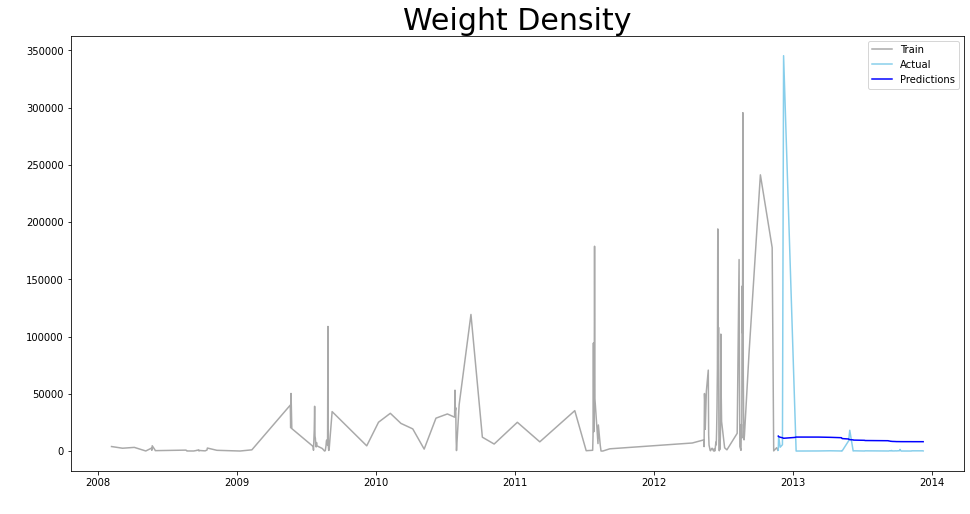

In [0]:
train = pollution_data_4_GroupByDate.filter(['Weight_Density_Class4Plastic'])[:training_data_length_1]
valid = pollution_data_4_GroupByDate.filter(['Weight_Density_Class4Plastic'])[training_data_length_1:]
valid ['Predictions'] = Predictions

plt.figure(figsize=(16,8))
plt.title('Weight Density', fontsize = 30)
plt.xlabel('Date', fontsize = 15, color = 'W')
plt.ylabel('Weight Density per Unit Area', fontsize = 15, color = 'W')
plt.plot(train['Weight_Density_Class4Plastic'], color = 'darkgray')
plt.plot(valid['Weight_Density_Class4Plastic'], color = 'skyblue')
plt.plot(valid['Predictions'], color = 'blue')
plt.legend(['Train', 'Actual', 'Predictions'], loc = 'upper right')
plt.show()

In [0]:
valid

,Weight_Density_Class4Plastic,Predictions
Date,,
2012-11-24,677.59,13034.068359
2012-11-25,12979.69,12549.714844
2012-11-29,3336.17,12078.447266
2012-12-05,5547.20,11606.326172
2012-12-08,345374.40,11163.856445
2013-01-06,41387.81,11867.160156
2013-01-10,8.90,12206.008789
2013-03-10,73.90,12193.636719
2013-04-10,225.70,11977.583984


In [0]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train_2.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.fit(X_train_2, y_train_2, batch_size = 1, epochs = 1)

test_data_2 = scaled_data_2[training_data_length_2 - 30:, :]

X_test_2 = []
y_test_2 = Dataset_2[training_data_length_2:, :]

for i in range(30, len(test_data_2)) :
  X_test_2.append(test_data_2[i-30: i, 0])

X_test_2 = np.array(X_test_2)

X_test_2 = np.reshape(X_test_2, (X_test_2.shape[0], X_test_2.shape[1], 1))

Predictions = model.predict(X_test_2)
Predictions = scaler.inverse_transform(Predictions)

RMSE = np.sqrt(np.mean(Predictions - y_test_2)**2)

RMSE

Epoch 1/1
118/118 [==============================] - 3s 28ms/step - loss: 0.0186


5172.4420083755485

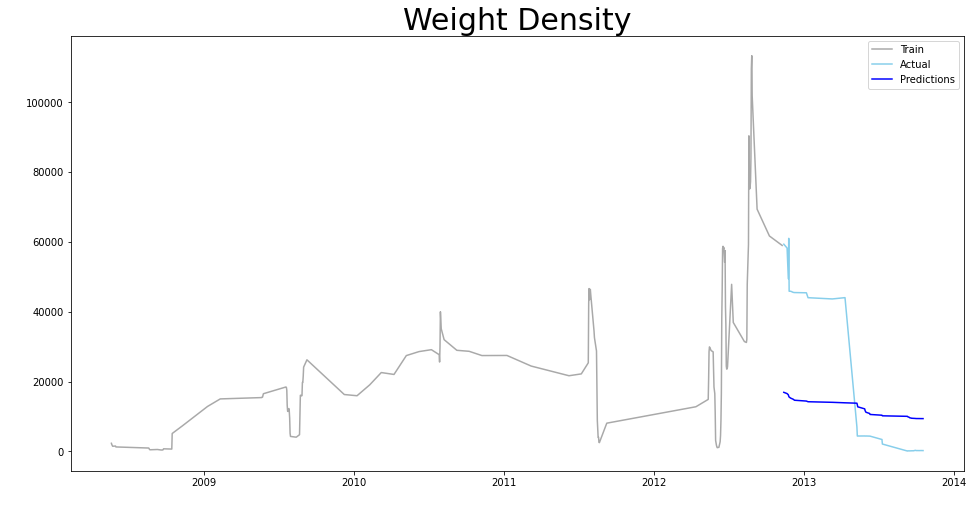

In [0]:
train = pollution_data_4_GroupByDate.filter(['Plastic_Moving_Average_9']).dropna(how='any')[:training_data_length_2]
valid = pollution_data_4_GroupByDate.filter(['Plastic_Moving_Average_9']).dropna(how='any')[training_data_length_2:]
valid ['Predictions'] = Predictions

plt.figure(figsize=(16,8))
plt.title('Weight Density', fontsize = 30)
plt.xlabel('Date', fontsize = 15, color = 'W')
plt.ylabel('Weight Density per Unit Area', fontsize = 15, color = 'W')
plt.plot(train['Plastic_Moving_Average_9'], color = 'darkgray')
plt.plot(valid['Plastic_Moving_Average_9'], color = 'skyblue')
plt.plot(valid['Predictions'], color = 'blue')
plt.legend(['Train', 'Actual', 'Predictions'], loc = 'upper right')
plt.show()

In [0]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train_3.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.fit(X_train_3, y_train_3, batch_size = 3, epochs = 3)

test_data_3 = scaled_data_3[training_data_length_3 - 30:, :]

X_test_3 = []
y_test_3 = Dataset_3[training_data_length_3:, :]

for i in range(30, len(test_data_3)) :
  X_test_3.append(test_data_3[i-30: i, 0])

X_test_3 = np.array(X_test_3)

X_test_3 = np.reshape(X_test_3, (X_test_3.shape[0], X_test_3.shape[1], 1))

Predictions = model.predict(X_test_3)
Predictions = scaler.inverse_transform(Predictions)

RMSE = np.sqrt(np.mean(Predictions - y_test_3)**2)

RMSE

Epoch 1/3
109/109 [==============================] - 2s 14ms/step - loss: 0.0124
Epoch 2/3
109/109 [==============================] - 1s 9ms/step - loss: 0.0116
Epoch 3/3
109/109 [==============================] - 1s 8ms/step - loss: 0.0121


15918.744424074259

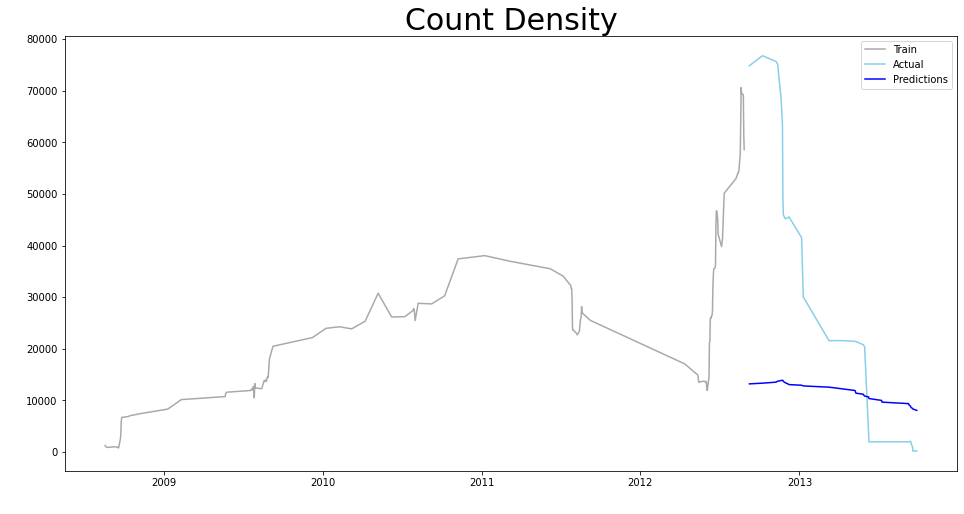

In [0]:
train = pollution_data_4_GroupByDate.filter(['Plastic_Moving_Average_21']).dropna(how='any')[:training_data_length_3]
valid = pollution_data_4_GroupByDate.filter(['Plastic_Moving_Average_21']).dropna(how='any')[training_data_length_3:]
valid ['Predictions'] = Predictions

plt.figure(figsize=(16,8))
plt.title('Weight Density', fontsize = 30)
plt.xlabel('Date', fontsize = 15, color = 'W')
plt.ylabel('Weight Density per Unit Area', fontsize = 15, color = 'W')
plt.plot(train['Plastic_Moving_Average_21'], color = 'darkgray')
plt.plot(valid['Plastic_Moving_Average_21'], color = 'skyblue')
plt.plot(valid['Predictions'], color = 'blue')
plt.legend(['Train', 'Actual', 'Predictions'], loc = 'upper right')
plt.show()

In [0]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train_4.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.fit(X_train_4, y_train_4, batch_size = 3, epochs = 3)

test_data_4 = scaled_data_4[training_data_length_4 - 30:, :]

X_test_4 = []
y_test_4 = Dataset_4[training_data_length_4:, :]

for i in range(30, len(test_data_4)) :
  X_test_4.append(test_data_4[i-30: i, 0])

X_test_4 = np.array(X_test_4)

X_test_4 = np.reshape(X_test_4, (X_test_4.shape[0], X_test_4.shape[1], 1))

Predictions = model.predict(X_test_4)
Predictions = scaler.inverse_transform(Predictions)

RMSE = np.sqrt(np.mean(Predictions - y_test_4)**2)

RMSE

Epoch 1/3
97/97 [==============================] - 1s 15ms/step - loss: 0.0107
Epoch 2/3
97/97 [==============================] - 1s 8ms/step - loss: 0.0108
Epoch 3/3
97/97 [==============================] - 1s 9ms/step - loss: 0.0102


30132.403755180287

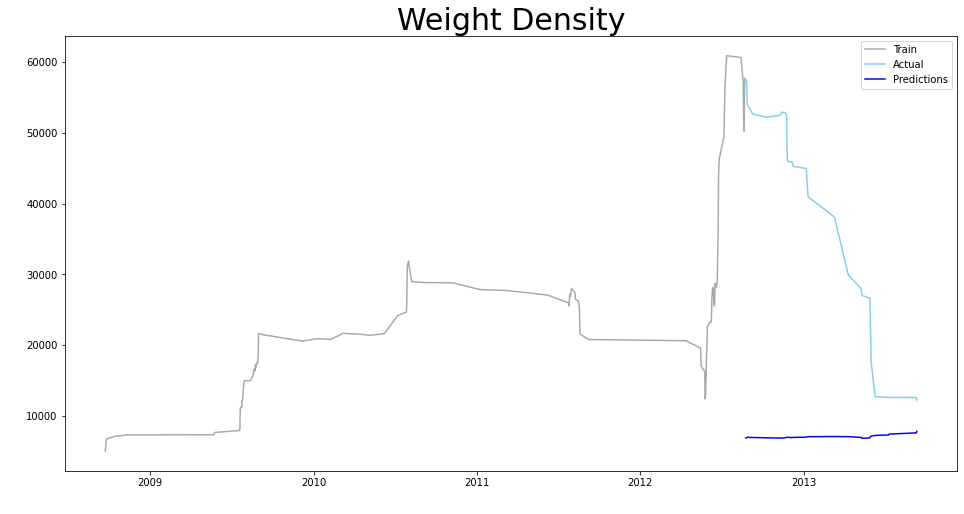

In [0]:
train = pollution_data_4_GroupByDate.filter(['Plastic_Moving_Average_36']).dropna(how='any')[:training_data_length_4]
valid = pollution_data_4_GroupByDate.filter(['Plastic_Moving_Average_36']).dropna(how='any')[training_data_length_4:]
valid ['Predictions'] = Predictions

plt.figure(figsize=(16,8))
plt.title('Weight Density', fontsize = 30)
plt.xlabel('Date', fontsize = 15, color = 'W')
plt.ylabel('Weight Density per Unit Area', fontsize = 15, color = 'W')
plt.plot(train['Plastic_Moving_Average_36'], color = 'darkgray')
plt.plot(valid['Plastic_Moving_Average_36'], color = 'skyblue')
plt.plot(valid['Predictions'], color = 'blue')
plt.legend(['Train', 'Actual', 'Predictions'], loc = 'upper right')
plt.show()